# Classification d'émotions dans la parole avec un modèle Bayésien naïf.

Dans ce travail, vous allez travailler sur un corpus de parole où les locuteurs actent des émotions sur un texte prédéfini. Ce corpus s'appelle Emo-DB, et la documentation complète est accessible ici : http://emodb.bilderbar.info/docu/ et la base de donnée est accessible sur la plateforme Kaggle (https://www.kaggle.com/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb)

10 locuteurs ont été enregistrés. 6 seront utilisés pour apprendre un modèle Bayésien naïf, les 4 locuteurs restant serviront à valider votre modèle. Nous aurons donc une évaluation indépendante du locuteur.

A l'origine, 6 émotions ont été exprimées lors de l'enregistrement du corpus. Pour simplifier le problème, nous avons réduit à deux classes notre problème de classification :
* C1 : colère, ennui, peur
* C2 : neutre, surprise, joie

In [1]:
from pathlib import Path
import pandas as pd
import scipy.io.wavfile as wav
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [37]:
%pip install colorama


Note: you may need to restart the kernel to use updated packages.


## 1) Feature extraction (à lire et exécuter que pour la partie 4)

Vous n'avez rien à faire dans cette section. Je vous la laisse pour comprendre comment sont construits les différents fichiers que vous aurez à traiter par la suite.

Pour construire un modèle à partir d'une base de donnée audio, il faut extraire des descripteurs du signal de parole. Généralement ces descripteurs sont issus de la théorie du traitement numérique du signal et du modèle source-filtre de la parole.

Nous considérons ici, l'extraction des descripteurs comme une boîte noire qui prend en entrée un signal audio (fichier wav) et retourne un vecteur de caractéristiques pour l'ensemble du segment. La taille du vecteur ne dépend pas de la durée du signal audio.

La boîte noire que nous allons utiliser est celle d'OpenSmile (https://audeering.github.io/opensmile-python/). Le contenu des vecteurs de caractéristiques varie suivant la configuration choisie. Une des configurations les plus utilisées s'appelle eGeMAPS, c'est celle que nous utiliserons. Elle permet de représenter un segment de parole émotionnelle sous forme d'un vecteur de 88 valeurs continues.

In [6]:
import opensmile
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
# affichage des noms des descripteurs audio qui sont extraits pour chaque fichier audio.
feat = smile.feature_names
print(','.join(feat))

F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amea

In [7]:
corpus_dir = '/Users/jimenezalfonso/Documents/UniversitéDuMaine/Maths/DM/emodb/'
# dictionnaire de correspondance entre les classes d'émotion en allemand vers anglais
# emo2emo = {'W':'A', 'L':'B', 'E':'D', 'A':'F', 'F':'H', 'T':'S', 'N':'N'}
# dictionnaire de correspondance entre les classes d'émotion en allemand vers nos 2 classes. 
# La correspondance na n'est pas prise en compte dans l'extraction des descripteurs.
emo2cl = {'W':'NEG', 'L':'IDL', 'E':'NEG', 'A':'NEG', 'F':'IDL', 'T':'NEG', 'N':'IDL'}


def write_extract_features(corpus_dir, spk_list, csvfile):
    """
        Cette fonction crée un fichier contenant l'ensemble des descripteurs obtenus pour chaque fichier audio,
        ainsi que la classe d'émotion correspondante: Name,desc1,desc2,...,desc88,Emo
        - corpus_dir: chemin vers les fichiers audio
        - spk_list: liste des locuteurs considérés pour la création du fichier
        - csvfile: nom du fichier
    """
    header = 'Name,'+','.join(feat)+',Emo\n'
    with open(csvfile, 'w') as f:
        f.write(header)
        for file in Path(corpus_dir).glob('*.wav'):
            
            tab = str(file).split('/')[-1]
            spk = tab[:2]
            if spk not in spk_list:
                continue
            text = tab[2:5]
            emo = emo2cl[tab[5]]
            if emo == 'na':
                continue
            sr, y = wav.read(corpus_dir + tab)
            x = smile.process_signal(y,sr)
            f.write(tab + ',')
            f.write(','.join(str(x.values[0][i]) for i in range(88)))
            f.write(',' + emo + '\n')




--------------------------
A partir de maintenant, nous pouvons extraire l'ensemble des descripteurs des ensembles d'apprentissage et de test fichier par fichier.

Si vous souhaitez modifier la répartition des classes émotionnelles, et/ou faire une classification à plusieurs classes, vous devrez regénérer ces fichiers. Mais pour la partie suivante, vous pouvez récupérer les fichiers directement sur le dépôt UMTICE.

### Extract train set features

In [6]:
spk_train = ['03', '08', '09', '10', '11', '12']
write_extract_features(corpus_dir, spk_train, 'emodb_train.csv')

### Extract test features

In [7]:
spk_test = ['13', '14', '15', '16']
write_extract_features(corpus_dir, spk_test, 'emodb_test.csv')

## 2) Analyse des données

Avant de choisir quel modèle vous souhaitez mettre en place, il va être nécessaire d'étudier les données pour voir comment elles sont organisées. Dans un premier temps on évaluera si tous les descripteurs sont pertinents : est-ce que certains sont très fortement corrélés ? d'autres ont peut-être une variance presque nulle, etc... Dans un second temps on cherchera à savoir la loi de probabilité qui est la plus adaptée pour décrire la distribution des données. 

### Chargement des données d'apprentissage et de test

Pour charger les données on utilisera la librairie pandas. Si vous êtes plus à l'aise avec numpy, c'est possible de convertir les DataFrame de pandas en numpy avec la méthodes `to_numpy()`

Vous pouvez charger directement les données fournies au format CSV avec le code ci-dessous. Ainsi vous n'avez pas besoin d'effectuer le calcul des descripteurs et d'écrire le CSV, cette étape (partie 1) est déjà faite pour ce TP.

In [8]:
# on récupère deux panda dataframe contenant les noms des fichiers, les descripteurs associés et l'émotion réelle.
train_data = pd.read_csv('./emodb/Emodb-Train.csv')
test_data = pd.read_csv('./emodb/Emodb-Test.csv')

# to get column names
feat_names = train_data.columns.values



**Q1** À partir des données d'apprentissage uniquement, tracer la distribution de quelques descripteurs. Donner le type des descripteurs (continu, discret), et la loi (ou les lois) qui permet de décrire au mieux ces données. Vous justifierez au maximum votre réponse. Il est possible que certains descripteurs soient inutiles, vous prendrez soin de nettoyer vos données avant de passer à la suite.

,Name,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,MeanUnvoicedSegmentLength,equivalentSoundLevel_dBp,Emo
0,16a02Lb.wav,6.262919,0.010610,6.197350,6.270048,6.320696,0.123346,4.228320,2.176092,4.337814,2.175941,3.592263,0.079502,-8.714741,-0.111558,2.058742,0.798866,0.308419,6.753431,3.340896,0.918614,-4.926859,17.019814,-0.056076,-0.006454,3.610488,14.975846,2.01,-3.041620,IDL
1,14a07Wc.wav,6.279079,0.010026,6.224029,6.285779,6.331894,0.107865,4.537495,1.409694,4.213212,2.438335,3.653819,0.070279,-8.735238,-0.117153,1.531482,1.019954,0.378829,4.826475,2.970865,0.946427,-4.873331,16.890736,-0.055527,-0.007568,3.670434,12.682927,1.99,-3.034599,NEG
2,13a05Ea.wav,6.260024,0.011503,6.201358,6.260698,6.324227,0.122869,5.048801,2.726339,4.459061,2.147691,3.643241,0.061500,-8.607537,-0.123021,2.010342,0.800482,0.702720,3.120612,3.527978,0.668688,-4.979615,17.112322,-0.056090,-0.006798,3.648725,14.832537,4.12,-3.001731,NEG
3,14a05Wa.wav,6.184681,0.046856,6.179664,6.256613,6.316103,0.136439,17.524170,13.486859,14.399488,14.137671,3.825741,0.139932,-7.328643,-0.464720,2.354858,1.087454,0.608574,4.514963,3.449360,0.809093,-5.254242,17.240854,-0.056546,-0.007594,3.824241,2.255639,3.93,-3.063286,NEG
4,14a07Na.wav,6.257222,0.011843,6.198559,6.259011,6.319243,0.120685,5.439183,2.003984,3.373145,1.411008,3.632412,0.071471,-8.729172,-0.111599,2.118731,0.697503,0.436149,5.247312,3.147955,0.753145,-4.961756,17.131966,-0.055719,-0.006760,3.647952,12.980770,2.02,-3.022973,IDL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,14b01Fa.wav,6.198039,0.033552,6.162391,6.257033,6.325938,0.163547,7.709384,6.096373,6.908133,7.357744,3.811838,0.123694,-7.410302,-0.473017,2.332548,1.262304,0.612262,4.758429,3.315547,0.761535,-5.211851,17.247356,-0.055929,-0.007128,3.816788,8.235294,2.49,-3.068114,IDL
253,14a07Ld.wav,6.277539,0.011237,6.217519,6.273716,6.344179,0.126660,4.329467,1.919474,4.828889,2.517499,3.636523,0.072719,-8.564069,-0.132443,1.525579,1.068495,-0.555688,-3.920020,2.680041,0.922715,-4.941556,16.976643,-0.056102,-0.007509,3.653878,14.473684,2.22,-3.028049,IDL
254,15a07Ld.wav,6.276237,0.010116,6.229288,6.276063,6.327182,0.097894,4.386929,1.920229,5.039661,2.228906,3.625402,0.076092,-8.617097,-0.123971,1.538821,1.046097,-0.021920,-96.241090,3.343867,0.860059,-4.910882,17.058231,-0.056169,-0.006685,3.641733,15.642458,1.73,-3.043983,IDL
255,15a07Ac.wav,6.258681,0.016705,6.207706,6.270643,6.336177,0.128471,5.434454,3.459224,3.749412,1.966761,3.710222,0.082458,-8.486691,-0.239468,1.779979,1.210289,0.304715,8.549951,2.504653,1.211373,-5.210651,17.353956,-0.056240,-0.006943,3.737611,11.666667,1.74,-2.896181,NEG


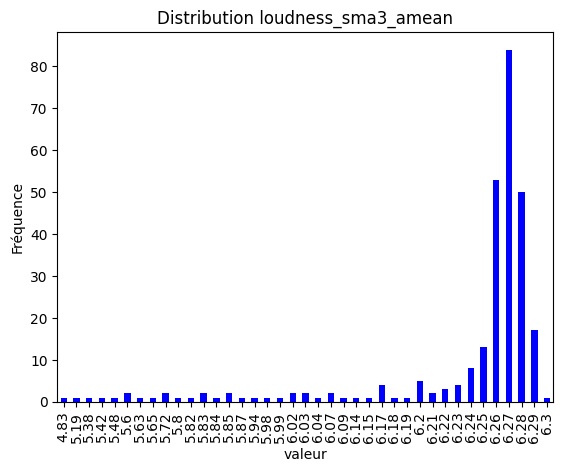

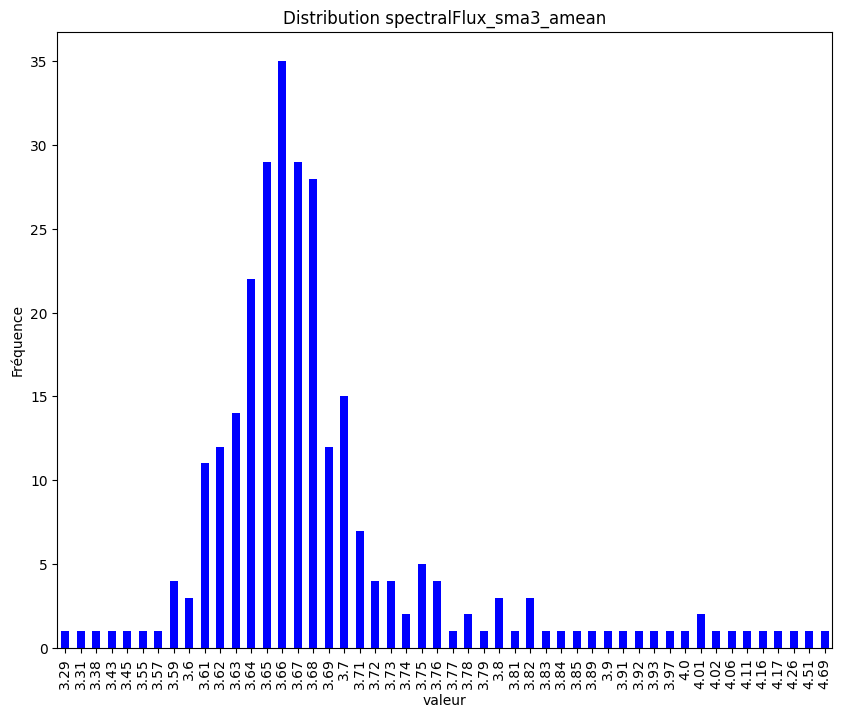

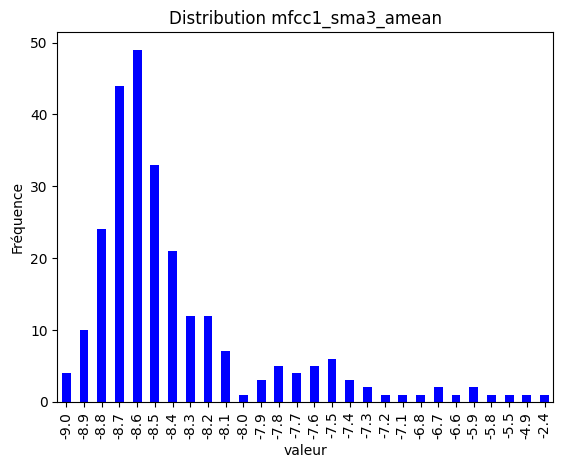

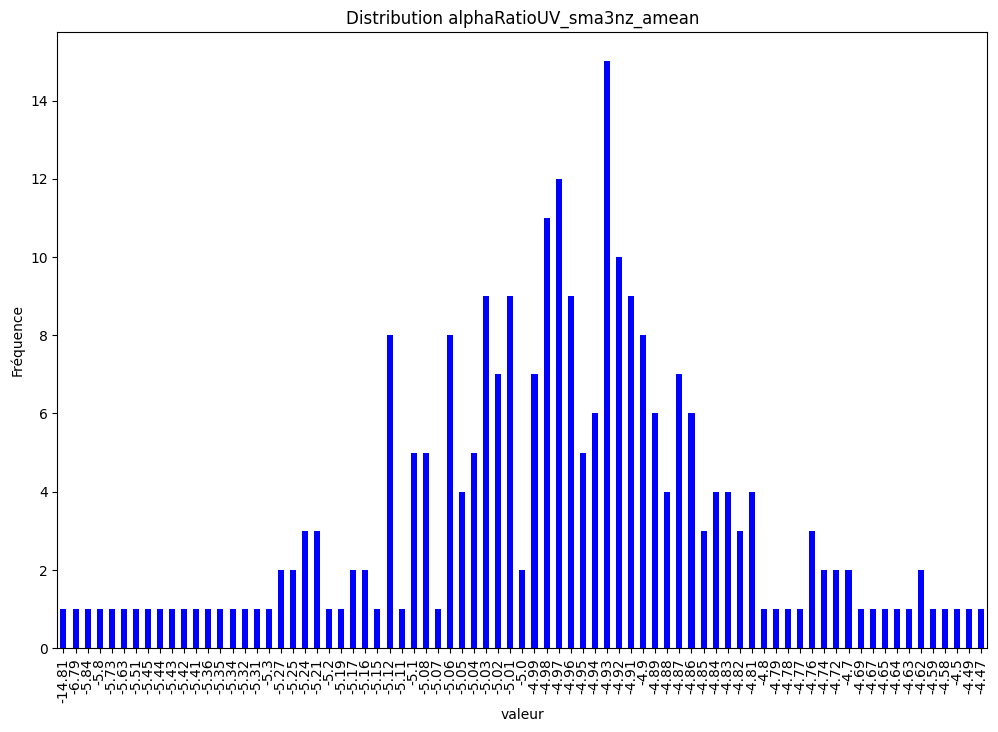

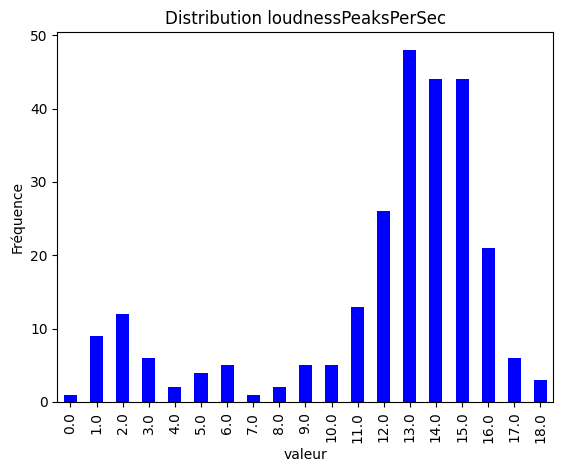

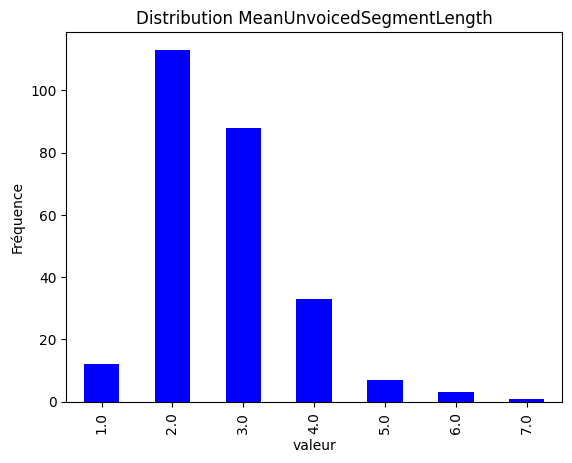

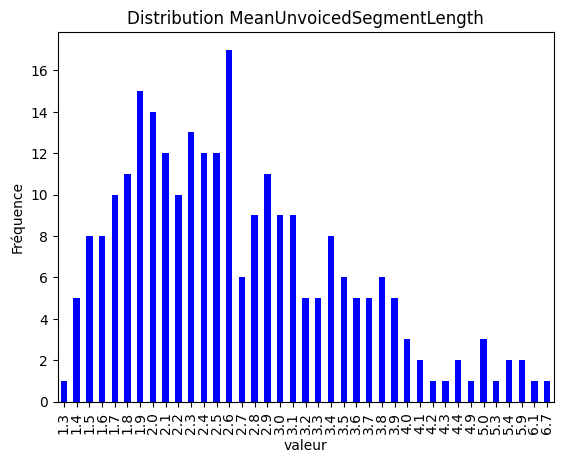

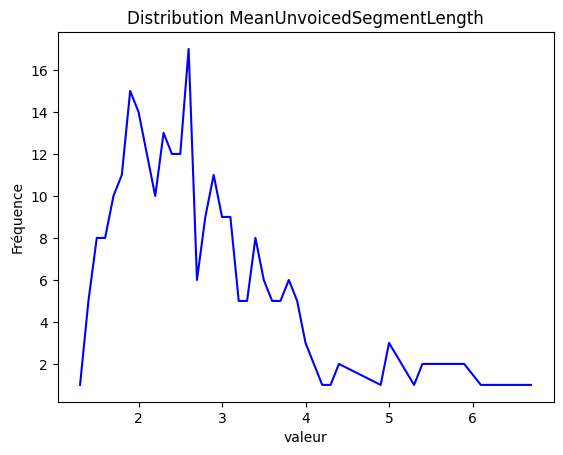

In [9]:


pd.set_option('display.max_columns', None)

# Netoyage des données

# Afin de nétoyer nos données le plus efficacement possible on cherche les colonnes
# qui ont une variance nulle. Ce qui vient a dire qu'ils ne donnent pas de l'information importante 
# pour le traitement des données et restent donc inutiles. 

# test_data
''' 
Cette méthode va netoyer les données du dataset en fonction de si toutes ses valeurs son égales, et donc
sa variance ne fournis pas de l'information importante pour le calcul de similarité dans le futur.
'''
def clean_data( data ):
    clean_data = pd.DataFrame()
    for i in range(0, feat_names.size):
        first_column = data.values[0][i]
        column_null = False
        colonne = list()
        for value in data.values:
            if( value[i] != first_column ): 
                column_null = True
                break
            
        if(column_null == True): 
            for value in data.values:
                colonne.append(value[i])
            clean_data[feat_names[i]] = colonne
    return clean_data

clean_test_data = clean_data(test_data)
clean_train_data = clean_data(train_data)

display(clean_test_data)
# display(clean_train_data)

# Traçage distribution quelques descripteurs
# Pour traçer la distribution de quelques decripteurs on devra graphiquer la valeur de notre descripteur 
# avec la frequence d'apparition de la valeur du descripteur respectif. 

# loudness_sma3_amean
clean_train_data["loudness_sma3_amean"].round(2).value_counts().sort_index().plot(kind='bar', color='blue')
plt.title("Distribution loudness_sma3_amean")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()

# spectralFlux_sma3_amean
clean_train_data["spectralFlux_sma3_amean"].round(2).value_counts().sort_index().plot(kind='bar', color='blue', figsize=(10,8))
plt.title("Distribution spectralFlux_sma3_amean")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()
# mfcc1_sma3_amean
clean_test_data["mfcc1_sma3_amean"].round(1).value_counts().sort_index().plot(kind='bar', color='blue')
plt.title("Distribution mfcc1_sma3_amean")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()
# alphaRatioUV_sma3nz_amean
clean_test_data["alphaRatioUV_sma3nz_amean"].round(2).value_counts().sort_index().plot(kind = 'bar', color='blue', figsize=(12,8))
plt.title("Distribution alphaRatioUV_sma3nz_amean")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()
# loudnessPeaksPerSec
clean_test_data["loudnessPeaksPerSec"].round(0).value_counts().sort_index().plot(kind='bar', color='blue')
plt.title("Distribution loudnessPeaksPerSec")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()
# MeanUnvoicedSegmentLength
clean_test_data["MeanUnvoicedSegmentLength"].round(0).value_counts().sort_index().plot(kind='bar', color='blue')
plt.title("Distribution MeanUnvoicedSegmentLength")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()

clean_test_data["MeanUnvoicedSegmentLength"].round(1).value_counts().sort_index().plot(kind='bar', color='blue')
plt.title("Distribution MeanUnvoicedSegmentLength")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()

clean_test_data["MeanUnvoicedSegmentLength"].round(1).value_counts().sort_index().plot(color='blue')
plt.title("Distribution MeanUnvoicedSegmentLength")
plt.xlabel("valeur")
plt.ylabel("Fréquence")
plt.show()

# Type du descripteur


# Quelles lois permettent de décrire au mieux ces données



# Question 1

## Description des données utilisées

Les données qu'on est entrain de manipuler sont des données quantitatives et qualitatives. On peut prendre l'exemple de la colonne 'Emo' par exemple qui est qualitative, ou même la colonne 'Name'. Hors, les données qu'on utilisera pour le traitement de ces dataset seront quantitatives. Le but étant d'avoir comme résultat une donnée qualitative en analysant les données quatitatives offertes par ces données.

## Utilisation de la variable feat_names

On utilise la variable feat_names afin de parcourir nos données en ayant toujours accès de manière facile a leur nom grâce a feat_names.
Hors, selon l'énoncé cette variable devrait être utilisé uniquement dans le cas ou on souhaiterais modifier la repartition des emotions. Néanmoins je trouve qu'elle est très utile pour le traitement de nos données tel quel. 

## Traçage de la distribution

Il est important de comprendre nos données avant de tracer leur distribution
On utilisera la fonction de fréquence (pour pandas cela serait value_counts()) afin de tracer la distribution des descripteurs. 
Les descripteurs qu'on à choisit de traçer sont les suivants : 

- loudness_sma3_amean
- spectralFlux_sma3_amean
- mfcc1_sma3_amean
- alphaRatioUV_sma3nz_amean
- loudnessPeaksPerSec
- MeanUnvoicedSegmentLength

En traçant la distribution de ces descripteurs on pourra évaluer leur normalité. Cela vient à dire qu'on pourrait comparer ces données, plus spécifiquement la distribution des mêmes, afin de voir si elles suivent une loi normale. Ou au contraire un loi uniforme, asymetrique, etc...

## Type

Ces descripteurs ont tous une chose en commun, cela étant qu'ils contiennent des valeurs continues. Ils existent plusieures manières d'identifier cela : Premierement ils ont tous des numeros qui sont accompagnés d'une virgule. De plus ils ne montrent pas visuellement une limite qu'ils ils ne pourront pas dépasser dans l'axis X. Afin de determiner avec plus de précision s'ils leur continuité il faudrait avoir accès au Dictionnaire des données. 

Dans tous les cas, avec l'information qui nous est disponible on peu conclure que les données que les descripteur qu'on est entrain d'analyser actuellement sont de type continu. Dans le cas ou le Dictionnaire des données précise que les valeurs d'un certain descripteur sont définis au millième près on pourrait encore dire que c'est une variable continu qui à été discretisé à une certaine précision.

## Loi 

*loudness_sma3_amean*

Dans une première instance, si on arrondi nos données et on les ordonne pas par défault ; pandas va les afficher en donnant l'apparence d'une fonction ln(x)/x. Il est important de les ordonner avec la fonction (sort_index()). Dans ce cas, en arrondissant au centième près on se rend compte que la distribution de ce descripteur se ressemble effectivement à une loi normale avec μ = 6.27.

*spectralFlux_sma3_amean*

Ce descripteur suit une loi normale avec μ = 3.65. On voit un petit pic dans 3.83. Hors si on spécifie un peu plus la courbe en allant au millier près ce pic semble se disperser. Donc on ne peut pas supposer, qu'il existent deux loi normales entrain de se superposer. 

*mfcc1_sma3_amean*

Pour ce descripteur on décide de faire un arrondissement au dixième près puisque les données sont moins précises. De même que pour spectralFlux_sma3_amean, au dixième près on peu voir un très grand pic suivi dans très petit pic. Hors ce pic se disperse quand on trace la distribution au centième près. On suppose que ce descripteur suit une loi normale avec μ = - 8.6.

*alphaRatioUV_sma3nz_amean*

Dans ce descpriteur on décide de la tracer avec un arrondissement au centième près. La graphication de descripteur a bel et bien été difficile en vue du nombre de valeurs à tenir en compte puisque. En fait ce descripteur à eu besoin de beaucoup de précision pour evaluer sa normalité dans les conditions correctes. On peut dire qu'il suit une loi normale avec μ = - 4.93.

*loudnessPeaksPerSec*

Le distribution du descripteur loudnessPeaksPerSec arrondie à l'unité près suit une loi normale avec μ = 13.5. On constate aussi qu'une deuxième loi normale est superposé: avec μ = 2.0 et une hauteur = 12.

*MeanUnvoicedSegmentLength*

Ceci est un descripteur qui suit une clairement loi normale lorsqu'on lui arrondie à l'unité près. On constate que sa distribution suit une loi normale avec μ = 2.0. Si on l'arrondi au dixième près il est plus difficile d'estimer une loi normale, pourtant il est encore possible de le modèliser de cette manière.


**Q2** Maintenant que vos données sont un peu plus propres, vous pouvez estimer à quel point les descripteurs sont indépendants. Proposer pour cela une méthodologie d'analyse en justifiant vos choix. En déduire certaines propriétés des descripteurs par rapport à nos données d'apprentissage.

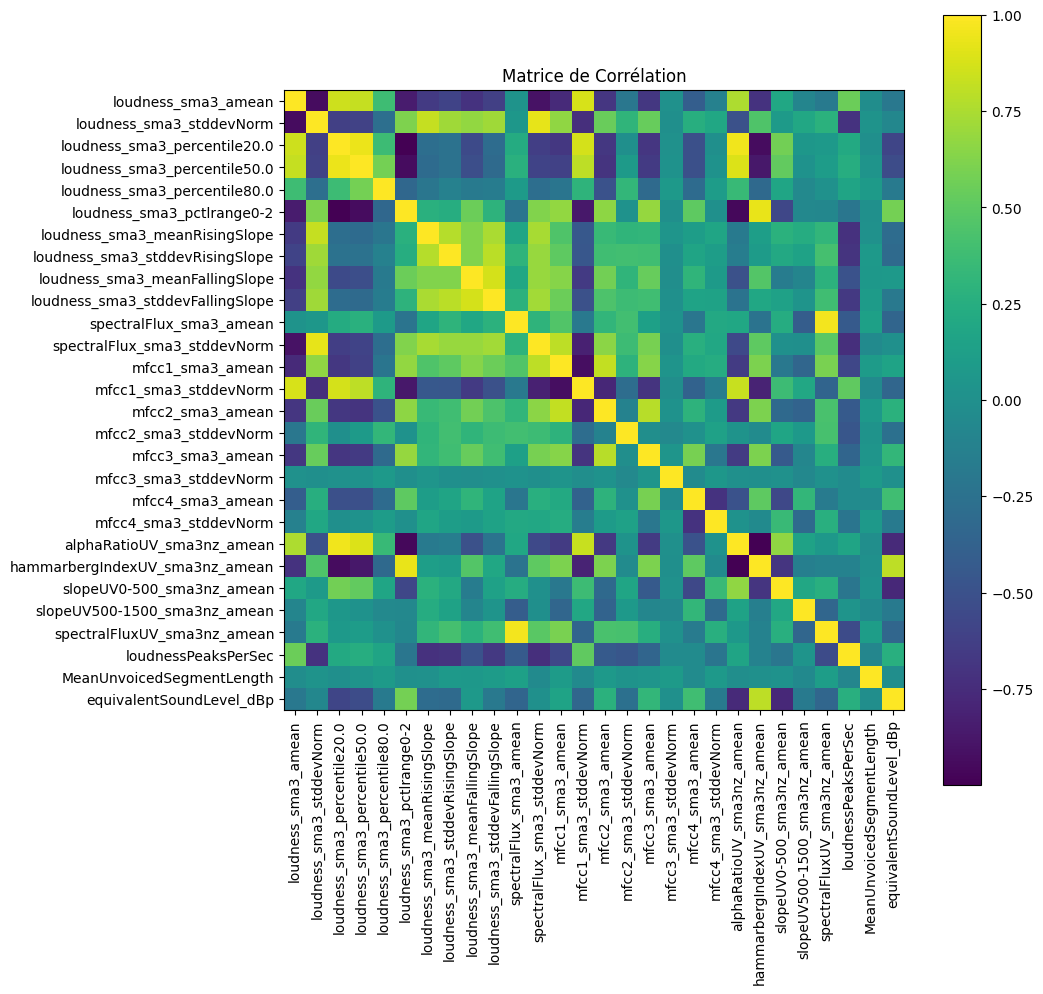

In [10]:
# Matrice de correlation

# On cherche à avoir des variables indépendantes dans nos données afin de pouvoir avoir accès a 
# nouvelle information pour chaque descripteur. Si deux descripteur ne sont pas indépendants.
# Il n'est pas nécessaire de stocker les deux puisque le deuxième descripteur est rédondant.

# Estimer a quel point nos descripteurs sont indépendants

# dataset test avec que les données quantitatives
only_data_test = clean_test_data.copy()
only_data_test.drop("Name", axis=1, inplace=True)
only_data_test.drop("Emo", axis=1, inplace=True)

# dataset train avec que les données quantitatives
only_data_train = clean_train_data.copy()
only_data_train.drop("Name", axis=1, inplace=True)
only_data_train.drop("Emo", axis=1, inplace=True)

matrice_correlation  = only_data_test.corr()

plt.figure(figsize=(10, 10))

matrice_plote = plt.imshow(matrice_correlation, cmap='viridis')
plt.colorbar(matrice_plote)

plt.xticks(ticks=np.arange(len(matrice_correlation.columns)), labels=matrice_correlation.columns, rotation=90)
plt.yticks(ticks=np.arange(len(matrice_correlation.columns)), labels=matrice_correlation.columns)

plt.title("Matrice de Corrélation")
plt.show()

# Déduire des proprietés par rapport à nos données d'apprentissage




## Question 2

### Proposition d'une méthodologie d'analyse afin d'estimer a quel point les descripteurs sont indépendants

Afin d'estimer a quel point les descripteurs sont indépendants il convient d'utiliser la matrice de correlation
On sait que si on calcule la correlation entre deux descripteurs et que cette correlation est égale à 1. 
Cela veut dire que ces descripteurs sont très correllés et donc ils sont très peu indépendants. 
La correlation est donc un très bon point de reference afin d'identifier l'indépendance des descripteurs
Ce processus aurait besoin de créer une méthode qui calcule la matrice en utilisant la formule de la correlation : 

$\displaystyle ρ = \frac{Cov(x_{1}, x_{2})} {σ1σ2} $ 

Heureusement cela n'est pas nécessaire puisqu'il existe déjà une fonction qui nous aide à calculer la matrice de correlation.

Mais, on ne peut pas réaliser la matrice de correlation de notre matrice comme cela, il faut prendre en compte uniquement les descripteurs dont leurs valeur est quantitative. Une fois nos données nétoyées pour une deuxième fois, on peut finalement tracer la matrice de correlation. 

Une autre option aurait pû être de réaliser la matrice de covariance. Hors, cet matrice est plus difficile à lire puisqu'elle n'est pas normalisé donc la matrice de correlation est plus adaptés à nos besoins. 

### Déduire des proprietés par rapport à nos données d'apprentissage

On peut visualiser grâce a notre matrice de correlation que nos données sont de manière majoritaire pas indépendantes. Ils existent certains descripteurs indépendants entre eux comme par exemple loudness-percentile-20 et loundness-pctlrange0-2. Hors on ne possède pas un descripteur qui est complétement indépendant avec l'ensemble du reste de descripteurs. Ce qui est logique sachant que ce sont des données qui proviennent du même audio. C'est ainsi qu'on devra se poser la question quel est le seuil à dépaser afin que nos données soient consiferées comme suffisament indépendantes pour apporter des nouvelles informations. 



## 3) Construction d'un modèle Bayesien Naïf 

Dans cette seconde partie vous devez implémenter un modèle Bayésien Naïf. Les paramètres du modèles, c'est-à-dire les paramètres correspondant à la loi de probabilité que vous allez utilisée, seront obtenus à partir des données d'apprentissage.

Les données de test serviront à évaluer la qualité en termes de performance de votre modèle. Vous ne devez en AUCUN cas les utiliser pour déterminer les paramètres du modèle.


**Q3** A partir des éléments de code donnés ci-dessous, calculer la probabilité a priori pour chacune des classes.

### Implementation d'un modéle Bayésien Naïf. 

#### Calculer la priorité à priori pour chacune des classes

*quelles sont nos classes ?*

Même si cette section peut être consideré inutile, c'ést important de donner contexte je pense.

A l'origine, 6 émotions ont été exprimées lors de l'enregistrement du corpus. Pour simplifier le problème, nous avons réduit à deux classes notre problème de classification :
* C1 : colère, ennui, peur
* C2 : neutre, surprise, joie

On definie la probabilité à priorité comme la probabilité qu'un événement se produise sur la base de connaissances préalables ou d'un raisonnement théorique, plutôt que de preuves empiriques. Dans notre cas sachant qu'on est entrain de faire des statistiques bayesiennes, la probabilité à priori est justement la probabilité d'avoir une telle classe en fonction de l'echantillon de données proportionnées.

Donc on devra calculer la frequence d'apparition d'une classe en fonction de la taille du corpus. De nos deux classes, donc P(C1) et P(C2). 
Assez facile, hors il est important de comprendre la définition de probabilité à priori.



In [11]:

# On commence à utiliser les données d'entrainement. J'espère que ça soit ce qu'il faut faire.
import colorama
from colorama import Fore, Style

# Resultat avec données de test

group = clean_test_data.groupby('Emo').size()
taille_echatillon = len(clean_test_data)
proba_a_priori_IDL = (group["IDL"] / taille_echatillon)*100
proba_a_priori_NEG = (group["NEG"] / taille_echatillon)*100

print("Probas a priori avec emodb_test.csv")
print(f"IDL : >>>>>>>>>>>> {Fore.RED}{proba_a_priori_IDL}{Style.RESET_ALL} <<<<<<<<<<<<<<<<<<<<")
print(f"NEG : >>>>>>>>>>>> {Fore.GREEN}{proba_a_priori_NEG}{Style.RESET_ALL} <<<<<<<<<<<<<<<<<<<<")

# Resultats avec données train

group = clean_train_data.groupby('Emo').size()
taille_echatillon = len(clean_train_data)

# Dans notre cas notre corpus de données est séparées par deux classes: IDL et NEG. 
proba_a_priori_IDL = (group["IDL"] / taille_echatillon)*100
proba_a_priori_NEG = (group["NEG"] / taille_echatillon)*100
print("Probas a priori Avec emodb_train.csv")
print(f"IDL : >>>>>>>>>>>> {Fore.RED}{proba_a_priori_IDL}{Style.RESET_ALL} <<<<<<<<<<<<<<<<<<<<")
print(f"NEG : >>>>>>>>>>>> {Fore.GREEN}{proba_a_priori_NEG}{Style.RESET_ALL} <<<<<<<<<<<<<<<<<<<<")




Probas a priori avec emodb_test.csv
IDL : >>>>>>>>>>>> 42.023346303501945 <<<<<<<<<<<<<<<<<<<<
NEG : >>>>>>>>>>>> 57.97665369649806 <<<<<<<<<<<<<<<<<<<<
Probas a priori Avec emodb_train.csv
IDL : >>>>>>>>>>>> 44.24460431654676 <<<<<<<<<<<<<<<<<<<<
NEG : >>>>>>>>>>>> 55.75539568345324 <<<<<<<<<<<<<<<<<<<<


**Q4** Pour chaque descripteur déterminer les paramètres de loi à partir des segments émotionnels de la base d'apprentissage. On rappelle que dans le cas Bernoulli, il faut déterminer la probabilité de succès de l'événement. Dans le cas multinomial, il faut déterminer la moyenne et l'écart-type de la densité de probabilité. 


C'est le moment de determiner les paramètres de la loi normale qui permettront de modeliser chaque descripteur.

- Dans quel cas on est dans le cas bernouilli ?
- Dans quel cas on est dans le cas multinomial ?

Toutes les données dont on souhaite determiner les paramètres de loi sont multinomiales, ce qui veut dire qu'elles ne correspondent pas à un cas de Bernouilli, puisque nos données sont des valeurs a virgulle flottante, donc il serait inutile de calculer le cas de Bernouilli. 

Comme un rappel, les paramètres d'une loi de bernouilli seront obtenus en faisant la somme des cas ou l'evenement est vrai divisé par le nb totales d'expériences. 

Dans le cas multinomial on possède la fonction .mean() qui nous permettra de calculer la moyenne de notre descripteur et .std() qui calculera l'écart type du descripteur. On va stocker ces informations pour dans une liste d'adjacence pour un usage futur.
J'ai décidé d'afficher les 6 descripteurs que j'ai analysé dépuis le principe. 

- loudness_sma3_amean
- spectralFlux_sma3_amean
- mfcc1_sma3_amean
- alphaRatioUV_sma3nz_amean
- loudnessPeaksPerSec
- MeanUnvoicedSegmentLength

Additionnellement on va calculer la moyenne et ecart type de chaque descripteur en fonction de ssa classe. 
Données qui nous seront très utiles pour la suite du calcul de vraisemblance.


In [12]:
def parametres_loi( donnees ):
    liste_adjacence = dict()
    for nom_descripteur, valeurs_descripteur in donnees.items():
        liste_adjacence[nom_descripteur] = (valeurs_descripteur.mean(), valeurs_descripteur.std())
    return liste_adjacence

def parametres_loi_classe( donnees ):
    liste_liste_adjacence = list()
    for name, values in donnees.groupby("Emo"):
        values.drop("Name", axis=1, inplace=True)
        values.drop("Emo", axis=1, inplace=True)
        liste_liste_adjacence.append((name, parametres_loi(values)))
    return liste_liste_adjacence

def afficher_listes_adjacence( test_liste, train_liste, descriptor_list ):
    for descriptor in descriptor_list:
        print(f"Paramétres test_data: {Fore.LIGHTMAGENTA_EX}{descriptor}{Style.RESET_ALL}")
        moyenne, ecart_type = test_liste[descriptor]
        print(f"{moyenne}, {ecart_type}")
        print (f"Parametres train_data: {Fore.LIGHTMAGENTA_EX}{descriptor}{Style.RESET_ALL}")
        moyenne, ecart_type = train_liste[descriptor]
        print(f"{moyenne}, {ecart_type}")

""" 
On suppose que les deux listes sont de même taille
Vu que se sont des corpus des mêmes données
 """
def afficher_listes_liste_adjacence( liste_test, liste_train, descriptor_list ):
    for i in range(0, len(liste_test)):
        nom_test, liste_adj_test = liste_test[i]
        nom_train, liste_adj_train = liste_train[i]
        print(f"{Fore.YELLOW} Class test->{nom_test}, train->{nom_train} {Style.RESET_ALL}")
        afficher_listes_adjacence(liste_adj_test, liste_adj_train, descriptor_list)

parametres_loi_test = parametres_loi(only_data_test)
parametres_loi_train = parametres_loi(only_data_train)

descriptor_list = [ "loudness_sma3_amean", "spectralFlux_sma3_amean", "mfcc1_sma3_amean", "alphaRatioUV_sma3nz_amean",
             "loudnessPeaksPerSec", "MeanUnvoicedSegmentLength" ]


liste_liste_test = parametres_loi_classe(clean_test_data)
liste_liste_train = parametres_loi_classe(clean_train_data)

afficher_listes_liste_adjacence(liste_liste_test, liste_liste_train, descriptor_list)
print("===========================================")
afficher_listes_adjacence(parametres_loi_test, parametres_loi_train, descriptor_list)


 Class test->IDL, train->IDL 
Paramétres test_data: loudness_sma3_amean
6.247063974999999, 0.08313433404997328
Parametres train_data: loudness_sma3_amean
6.221328634959351, 0.1841369082833642
Paramétres test_data: spectralFlux_sma3_amean
3.6739759120370374, 0.0814494591849342
Parametres train_data: spectralFlux_sma3_amean
3.6622011430894306, 0.0944112524443095
Paramétres test_data: mfcc1_sma3_amean
-8.426004914814815, 0.5550850238360049
Parametres train_data: mfcc1_sma3_amean
-8.30518927886179, 0.9669032595343318
Paramétres test_data: alphaRatioUV_sma3nz_amean
-4.996454514814815, 0.22345354791765892
Parametres train_data: alphaRatioUV_sma3nz_amean
-5.063654717886179, 0.7860720090045957
Paramétres test_data: loudnessPeaksPerSec
12.661050560185185, 3.7523240450796496
Parametres train_data: loudnessPeaksPerSec
12.007860887642275, 4.021367951442625
Paramétres test_data: MeanUnvoicedSegmentLength
2.4837962648148153, 0.6934779157473486
Parametres train_data: MeanUnvoicedSegmentLength
2.49260

**Q5** Rappeler l'hypothèse naïve. Qu'en pensez-vous par rapport à l'analyse des données faites dans la partie 2 ?

### Rappel de l'hypothèse naive

L'hypothèse bayessienne naive va partir d'un faux principe à mésure que des nouvelles preuves deviennent disponibles. Elle va supposer que tous les descripteurs de nos données sont indépendants. Ce qui serait idéal dans un corpus. Pourtant cela ne sera jamais vraie dans notre echantillon. 

On à pu clairement voir qu'aucun des descripteur est completement indépendant du reste des descripteurs, ce qui pourrais même indiquer que l'hypothèse naive n'est pas très adapté pour modéliser ce système du réel. 

Si on prend l'exemple d'une boite à lettre numérique le modéle bayessien naif ne va prendre en compte l'ordre des mots ou s'ils sont des verbes ou des déterminants dans un mail. Le modèle va évaluer en supposant que chacune des elements du mail ont la même importance, ce qui rend du modèle bayesien très efficace dans ce modèle du réel. On dit que le modèle Bayesien Naif à un grand *biais* puisqu'elle ignore les régles du système et une basse *variance* parce qu'elle fonctionne très bien en pratique. 

**Q6** Construire une fonction qui calcule la vraisemblance d'un segment de test d'appartenir à la classe IDL ou NEG. Elle prendra en entrée les données d'apprentissage et un segment de test.

Afin de calculer la vraisemblance en utilisant le modèle bayesien naif. 
On veut calculer 

$ P( c = "IDL" \mid \mathbf{x}) $ et $ P( c = "NEG" \mid \mathbf{x}) $

On fait finalement façe à un problème de calcul de vraisemblance maximale suivant une loi normale. 
Il suffit uniquement de calculer la vraisemblance en remplaçant $\mu_c$ et $\sigma_c^2$ de la formule suivante :

$ P(x_i \mid c) = \frac{1}{\sqrt{2\pi\sigma_{i,c}^2}} \exp\left(-\frac{(x_i - \mu_{i,c})^2}{2\sigma_{i,c}^2}\right) $

Pour finalement trouver $ P( C=c \mid \mathbf{x} ) = P(C=c) \prod_{i=1}^{n} P(x_i \mid c) $



In [13]:
from decimal import Decimal

def vraisemblance( donnees , segment_test, classe ):
    # On calcule la moyenne et ecart type de segment test

    vraisemblance = float(1)
    
    for nom_colonne, colonne in segment_test.items():
        
        if not pd.api.types.is_numeric_dtype(colonne) : continue
        nom_colonne_liste, liste_adjacence = liste_liste_train[0] if classe == "IDL" else liste_liste_train[1]
        moyenne, ecart = liste_adjacence[nom_colonne]
        vraisemblance *= (1 / np.sqrt(2 * np.pi * ecart)) * ( np.exp( -((colonne - moyenne) ** 2) / (2 * ecart**2) ) )
    return vraisemblance


**Q7** Pour un segment de test dont on ne connait pas la classe émotionnelle, déterminer le maximum de vraisemblance. 

In [14]:

def vraisemblance_classes( donnees, segment_test ):
    v_idl = vraisemblance(clean_train_data, segment_test , "IDL")
    v_neg = vraisemblance(clean_train_data, segment_test, "NEG")
    return v_idl, v_neg

segment_test = clean_test_data.iloc[1]
v_idl, v_neg = vraisemblance_classes(clean_train_data, segment_test)
print(v_idl)
print(v_neg)
if(v_idl > v_neg): print(f"{Fore.MAGENTA}Maximum ressemblance : IDL{Style.RESET_ALL}") 
else : print("Maximum ressemblance NEG")
print( f"Reelle Emotion : {segment_test['Emo']}" )



3.2293555482159363e-06
3.024370539209162e-07
Maximum ressemblance : IDL
Reelle Emotion : NEG


**Q8** A partir de la vraisemblance et de la probabilité a priori, calculer la probabilité a posteri que le segment de test à partienne à une classe ou l'autre. Comparer votre résultat avec l'émotion réelle telle qu'annotée dans le corpus.

Contrairement à ce que je pensais : 
La formule mathématique de $ P( C = c | x) $ n'est pas

$ P(x_i \mid c) = \frac{1}{\sqrt{2\pi\sigma_{i,c}^2}} \exp\left(-\frac{(x_i - \mu_{i,c})^2}{2\sigma_{i,c}^2}\right) $

La formule correcte serais : 

$ P(x_i \mid c) = \frac{P(c)}{P(x)}  \frac{1}{\sqrt{2\pi\sigma_{i,c}^2}} \exp\left(-\frac{(x_i - \mu_{i,c})^2}{2\sigma_{i,c}^2}\right) $

Mais, pour le calcul maximum à posteriori $P(x)$ ne dépend pas de la classe mais de la distribution de données. Ce qui nous permet de dire que cette grandeur n'intervient pas dans la prise de décision. 

De manière recapitulative on pourrait dire qu'on à effectué la formule suivante : 
$ P(x_i \mid c) = \frac{1}{\sqrt{2\pi\sigma_{i,c}^2}} \exp\left(-\frac{(x_i - \mu_{i,c})^2}{2\sigma_{i,c}^2}\right) $ 

Maintenant on souhaite faire la continuation de cette formule afin de calculer le maximum à posteriori. 

Donc :  $ Decision = argmax_c\;  P(C=c) \prod_{i=1}^{n} P(x_i \mid c) $

In [15]:

def maximum_vraisemblences(segment_test):
    v_idl, v_neg = vraisemblance_classes(clean_train_data, segment_test)
    proba_a_posteriori_segment_IDL  = v_idl * proba_a_priori_IDL
    proba_a_posteriori_segment_NEG = v_neg * proba_a_priori_NEG
    # print(proba_a_posteriori_segment_IDL)
    # print(proba_a_posteriori_segment_NEG)
    if(proba_a_posteriori_segment_IDL > proba_a_posteriori_segment_NEG): 
        # print(f"{Fore.MAGENTA}Maximum ressemblance : IDL{Style.RESET_ALL}")
        return 'IDL'
    else :
        # print("Maximum ressemblance NEG")
        return 'NEG'

decision = maximum_vraisemblences(segment_test)
print( f"Reelle Emotion : {segment_test['Emo']}" )





Reelle Emotion : NEG


**Q9** Evaluer votre modèle en calculant le taux de bonnes réponses (accuracy) obtenu sur l'ensemble de test, c'est-à-dire le nombre de bonnes réponses sur le nombre total de segments de test. Vous deverez trouver un score légèrement supérieur à 50%.

In [16]:
accuracy = float(1)
nb_tests = 0
succes = 0

for nom, segment in clean_test_data.iterrows():
    decision = maximum_vraisemblences(segment)

    if decision == segment["Emo"]: succes+=1
    nb_tests+=1

accuracy = succes / nb_tests
print(f"Taux de bonnes reponses : { accuracy*100 }")

Taux de bonnes reponses : 57.97665369649806


Ici j'ai uniquement exécuté pour chacune des lignes du corpus emodb_test le calcul de la vraisemblence.
On a trouvé donc un taux de bonnes réponses ou accurracy égale à 57.97 %. Comme attendu. 

## 4) Comparaison de vos résultats avec sklearn

Enfin, je vous propose de comparer votre modèle avec une version implémentée dans la librairie `sklearn`. Plusieurs types de modèles sont possibles à choisir en fonction de vos données et votre problème: `MultinomialNB`, `GaussianNB`, `BernoulliNB`, etc...

`sklearn` fourni également un certain nombre de métriques très utiles en machine learning. Parmi celle-ci, la plus complète et adaptée aux problèmes de classification est la visualisation de la matrice de confusion. Cette matrice ($2 \times 2$ dans notre cas), permet de voir le nombre de segment correctement classés par classe.

In [2]:
%pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 14.2 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

L'apprentissage d'un modèle se fait avec les variables suivantes:
* `x_train`: matrice correspondant aux données (en lignes) et leurs descripteurs (en colonnes) pour **l'apprentissage** du modèle
* `y_train`: labels correspondant aux classes associés à chaque donnée d'apprentissage (vecteur)
* `x_test`: matrice correspondant aux données (en lignes) et leurs descripteurs (en colonnes) pour **l'évaluation** du modèle
* `y_pred`: labels prédits par le modèle sur les données d'évaluation `x_test`
* `y_test`: labels a priori inconnus correspondant aux classes associés à chaque donnée d'évaluation (vecteur)

**Q10** Apprendre un modèle équivalent à celui que vous avez implémenté en partie 3. Comparer les résultats obtenus avec les deux versions.

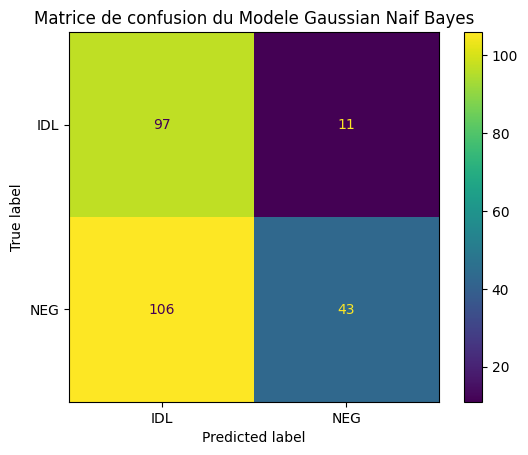

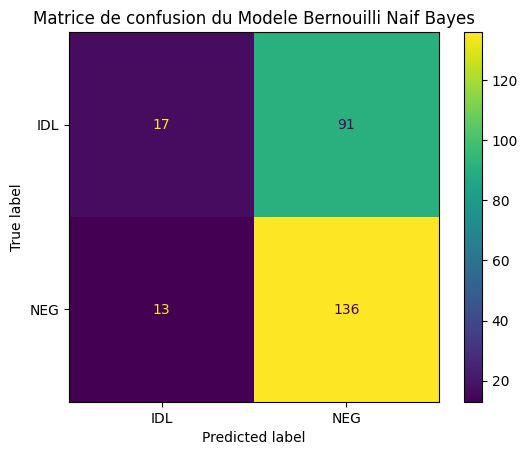

In [37]:

x_train = clean_train_data.drop(columns=["Name", "Emo"])
y_train = clean_train_data["Emo"]

x_test = clean_test_data.drop("Name", axis="columns")
x_test = x_test.drop("Emo", axis="columns")
y_test = clean_test_data.Emo


clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# affiche la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.title("Matrice de confusion du Modele Gaussian Naif Bayes")
plt.show()

clf = BernoulliNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# affiche la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.title("Matrice de confusion du Modele Bernouilli Naif Bayes")
plt.show()




Ici j'ai utilisé deux modéles pour calculer notre similiture. On peut voir que l'accuracy obtenue est très base, si on fait le calcul on trouverais aussi un taux de 50 % plus ou moins. En utilisant le modéle Gaussian on à les pires performances avec avec un total de 140 calculs de similaritudes correct sur 257 soit 54.4%. 

Le modèle Bernouilli à un total de 153 calcul de similaritude corrects d'un total de 257 expérience. Soit 59.5 %

Ce qui veut dire que notre modèle bayesien naif n'a pas encore atteint son maximum optimal par rapport à ce qui est possible. 

**Q11** Le modèle ne donne pas de très bons résultats. Qu'est-ce qui pose problème à votre avis, quels sont les éléments qui peuvent être améliorés ?

### Question 11

Le modèle bayesien naif part du principe qu'il n'ya aucune correlation entre les données. Hors, on l'a vue dans la partie 2 que cela n'est pas le cas. On a toujours une correlation entre les données. Même si elle est petite elle est présente. Ce qui va forcement rendre moins performant et précis à notre modèle, c'est pour cela qu'on dis que c'est un modèle avec un grand taux de "biais". Hors, on voit quand même que le modèle de bayes à un taux de prediction de plus de 50 % dans notre dataset. Ce qui n'est pas négligeable, mais n'est pas suffisament elevé pour être consideré comme un modèle précis.

Je suppose que si on tenais en compte la correlation entre nos descripteurs le résultat serait beaucoup plus précis, de plus si on essayait de filtrer les descripteurs qui ont le plus de correlation par rapport aux emotions d'un audio, et donc de les tenir uniquement en compte a ses descripteurs, et non pas aux autres descripteurs  qui pourraient être entrain de causer une fausse estimation. Un autre aspect serait aussi avoir un dataset plus grand, et donc qui nous aidera à identifier avec plus de détail la correlation entre certain descripteur et les emotions du segment.  

## 4) pour aller plus loin (bonus 2pts)

Dans cette dernière partie, je vous laisse libre de choisir la tâche que vous souhaitez réaliser.
Finalement, vous pouvez rafiner votre modèle avec une approche de votre choix, optimiser les descripteurs, faire une classification à plus que deux classes. Vous pouvez également comparer l'approche avec d'autres types de modèles disponibles dans `sklearn`. Vous pouvez également prendre en compte le genre des locuteurs, ou normaliser vos descripteurs (par exemple pour que les descripteurs soient centrés réduits).

Bon courage!

In [34]:
### TO COMPLETE
import numpy as np

u1 = np.array([0.2,2.2, -1.0])
u2 = np.array([-0.1,0.2, -1])
u3 = np.array([-1,0, -0.2])

a = u1*u3
b = u1.dot(u3)
c = u1.reshape(3,1).dot(u3.reshape(1,3))
c



array([[-0.2 ,  0.  , -0.04],
       [-2.2 ,  0.  , -0.44],
       [ 1.  , -0.  ,  0.2 ]])